<center> <h1> Agent-Based Model of Panic</h1> </center>

# Imports

In [1]:
from copy import deepcopy
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statistics
import numpy as np
import pyabc
from pyabc.transition.multivariatenormal import MultivariateNormalTransition

random.seed(1234)

# Define model class

In [186]:
class Model():

    def __init__(self, num_of_agents=10, num_iterations=10, mode ='homogeneous', verbose=False):
        self.agent_types = ['low', 'moderate', 'high'] 
        self.num_of_agents = num_of_agents
        self.num_iterations = num_iterations
        self.mode = mode
        self.verbose = verbose

        self.alpha = 0.1
        
        self.gamma = 0.1

        self.beta = 0.5
        
        #creating lists
        self.num_infected_per_iteration = list()
        self.num_low_sus_per_iteration = []
        self.num_mod_sus_per_iteration = []
        self.num_high_sus_per_iteration = []
        
        self.num_of_panicked = 0
        self.panicked_agents = list()
               
        #model time
        self.time = 0
        
        #create the agents, random.choice allocates agents to a type 
        self.agents = []
        for i in range(num_of_agents):
            # adding each new created agent to a list
            if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                self.agents.append(Agent(self))
            if self.mode == 'adv_heterogeneous':
                self.agents.append(Agent(self, agent_types=random.choice(self.agent_types)))
    
        
        # if the model hasn't finished running yet
        self.model_finished = False 
    
    def get_num_infected(self):
        #gets number of agents that are infected
        return len(([ a for a in self.agents if a.state==1 ]))

    def get_num_low_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='low' ]) 
    
    def get_num_mod_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='moderate' ]) 
    
    def get_num_high_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='high' ]) 
    
    def run(self):
        for t in range(self.num_iterations):
            for agent in self.agents: # every agent, in every iteration, moves forward
                agent.step()
            
            if self.verbose:
                for i, agent in enumerate(self.agents):
                    print('Agent {0}/{1}:'.format(i, self.num_of_agents))    
                    if self.mode == 'homogeneous':
                        print('my likelihood:{}, my state:{}'.format(agent.likelihood, agent.state))
            
            self.num_infected_per_iteration.append(self.get_num_infected())
#             self.num_low_sus_per_iteration.append(self.get_num_low_sus())
#             self.num_mod_sus_per_iteration.append(self.get_num_mod_sus())
#             self.num_high_sus_per_iteration.append(self.get_num_high_sus())
            if self.verbose:
                if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                    print('step: {},  total infected:{}'.format(t, self.get_num_infected()))
    #             if self.mode == 'adv_heterogeneous':
    #                 print('step: {}, low:{}, mod:{}, high:{}'.format(t, self.get_num_low_sus(), self.get_num_mod_sus(), self.get_num_high_sus()))
    
            #step time
            self.time += 1
        
        #once each iteration is done, model is finished
        self.model_finished = True 
        
        #creating a list of panicked agents, appending new ones after each new step                   
        panicked_agents = list()
        
        for agent in self.agents:
            if agent.state == 1:
                panicked_agents.append(agent)
        self.num_of_panicked = len(panicked_agents)
        self.panicked_agents.append(self.num_of_panicked)
        
        self.mean_panicked = round(statistics.mean(self.panicked_agents))

    def graph_num_infected(self):
        """
        Uses matplotlib to create a graph
        """
        if not self.model_finished:
            print("Can't print the number of infected until the model has finished")
            return
        
        # Create a figure and an axis (if you want more than one plot in the same
        # figure you can adjust the subplots function)
        
        fig, ax = plt.subplots(num=None, figsize=(5, 3), dpi=128, facecolor='w', edgecolor='k')
        
        # Do a scatter plot
        if self.mode == 'homogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration],
                    c="red", label=" Total infected") 
            
        if self.mode == 'heterogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration], "o-",
                    c="red", label=" Total infected") 
            
        if self.mode == 'adv_heterogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_low_sus_per_iteration], "o-",
                    c="green", label="No. Low Sus")
        
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_mod_sus_per_iteration], "o-",
                    c="orange", label="No. Mod Sus")
                
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_high_sus_per_iteration], "o-",
                    c="blue", label="No. High Sus")
        
        ax.set_title("Number of infected per iteration")
        ax.set_ylim(0,len(self.agents)) # limit the y axis
        ax.set_xlabel("Iteration (time)")
        ax.set_ylabel("Number of infected")
        ax.legend(loc='upper left')
        
        plt.savefig("Number of Infected Agents Through Time ", bbox_inches="tight")

## Defining agent class

In [190]:
class Agent():
    
    def __init__(self, model, alpha = 0.1, beta = 0.1, gamma= 0.1, agent_types = 'moderate'):
        
        self.agent_types = agent_types

        self.state = 0
        
        model.alpha = alpha
        
        model.gamma = gamma

        model.beta = beta 
        
        self.likelihood = 0

        
        self.likelihood_heterogeneous_one = []
        self.likelihood_heterogeneous_two = []
        
        #pointer to the model class
        self.model = model
        
        #For the simple heterogenous simulation, 
        #agents draw betas from normal distribution
        if model.mode == ['heterogeneous']:
            self.Beta = self.heterogeneous_model_one_beta

        
        #For the advanced heterogeneous sim, agents are allocated into a 
        #class of susceptibility, according to their agent type
        self.beta_low = self.low_sus()
        self.beta_mod = self.moderate_sus()
        self.beta_high = self.high_sus()

        r = random.random()
        
        #creating a list of all susceptibility classes.
        self.susceptibility = (self.low_sus, self.moderate_sus, self.high_sus) 
        
        if model.mode == ['adv_heterogenous']:
            if self.state == 0: 
                if random.random() <0.5:
                    self.susceptibility = self.low_sus()
                elif random.random() == 0.5:
                    self.susceptibility = self.moderate_sus()
                else:
                    self.susceptibility = self.high_sus()
       
    #Here, we create the different beta functions for the heterogeneous simulations. 
    def low_sus(self):
        return stats.norm.rvs(loc = 0.2, scale = 0.2)
        
    def moderate_sus(self):
        return stats.norm.rvs(loc = 0.4, scale = 0.2)
        
    def high_sus(self):
        return stats.norm.rvs(loc = 0.6, scale = 0.2)

    def heterogeneous_model_one_beta(self):
        return stats.norm.rvs(loc = 0, scale = 1)
    
    #Every time the heterogeneous simulations are ran, we update the betas 
    def update_beta(self):
        self.beta_low = self.low_sus()
        self.beta_mod = self.moderate_sus()
        self.beta_high = self.high_sus()
        
    def prob(self):
        return stats.norm.rvs(loc = 0, scale = 1) 

    def step(self):
        if self.state == 0: 
            self.homogeneous_model()
#             if model.mode == ['heterogeneous']:
#                 self.heterogeneous_model_one()
#           if model.mode ==['adv_heterogeneous']:
#               self.heterogeneous_model_two()
                
        else:
            self.recover()
            # print(self.state)
             
    def homogeneous_model(self):
            
        num_infected = model.get_num_infected()
            
        self.likelihood = model.alpha + (num_infected * model.beta) / model.num_of_agents
        
        #print(f"{self.likelihood}, {model.alpha}, {model.beta}, {num_infected}")
        
        r = random.random()
        
        if r < self.likelihood: 
            self.state = 1
         
    def heterogeneous_model_one(self):
        num_infected = model.get_num_infected()
        
        self.likelihood_heterogeneous_one = list()
        
        if model.mode == ['heterogeneous']:
            likelihood = self.alpha + (num_infected * self.heterogeneous_model_one_beta)
            
            if r < likelihood: 
                self.state = 1
            else:
                self.other_agents()
                
            self.likelihood_heterogeneous_one.append(self.likelihood)
    
  
    def heterogeneous_model_two(self):
        num_infected = model.get_num_infected()
        
        self.update_beta()
        
        r = random.random()
        
        self.likelihood_heterogeneous_two = list()
        
        if model.mode == ['adv_heterogeneous']: 
            self.likelihood_low_sus = self.alpha + (num_infected * self.beta_low)
            self.likelihood_moderate_sus = self.alpha + (num_infected* self.beta_mod)
            self.likelihood_high_sus = self.alpha + (num_infected * self.beta_high)
            
            if self.agent_types == 'low':
                if r < self.likelihood_low_sus:
                    self.state = 1
            elif self.agent_types == 'moderate':
                if r < self.likelihood_moderate_sus:
                    self.state = 1
            else: 
                self.agent_types =='high'  
                if r < self.likelihood_high_sus:
                    self.state = 1    
    
            self.likelihoods_low.append(self.likelihood_low_sus)
            self.likelihoods_mod.append(self.likelihood_moderate_sus)
            self.likelihoods_high.append(self.likelihood_high_sus)
            

    def other_agents(self):
        if model.num_of_panicked > model.num_of_agents/1.5:
            self.state = 1
            print("I became panicked after seeing others panic")
            
    
    def recover(self):
        r1 = random.random()
        if self.state == 1:
            if r1 < model.gamma:
                self.state = 0
            if r1 > 0.8:
                self.agent_types == 'low' or self.agent_types == 'moderate'
            
            else:
                self.agent_types =='high'
    

## Running model

[5,
 13,
 23,
 30,
 36,
 47,
 49,
 53,
 56,
 54,
 58,
 65,
 62,
 68,
 64,
 63,
 60,
 61,
 60,
 61,
 59,
 56,
 58,
 54,
 52,
 54,
 56,
 65,
 68,
 66,
 66,
 66,
 68,
 68,
 66,
 61,
 59,
 63,
 64,
 66,
 63,
 60,
 59,
 61,
 61,
 58,
 57,
 59,
 61,
 63,
 62,
 59,
 54,
 56,
 59,
 57,
 59,
 58,
 59,
 59,
 58,
 56,
 59,
 60,
 61,
 62,
 63,
 65,
 61,
 66,
 61,
 66,
 63,
 58,
 61,
 58,
 53,
 56,
 57,
 58,
 57,
 60,
 58,
 60,
 65,
 66,
 67,
 64,
 67,
 68,
 67,
 69,
 69,
 65,
 66,
 63,
 63,
 58,
 59,
 61]

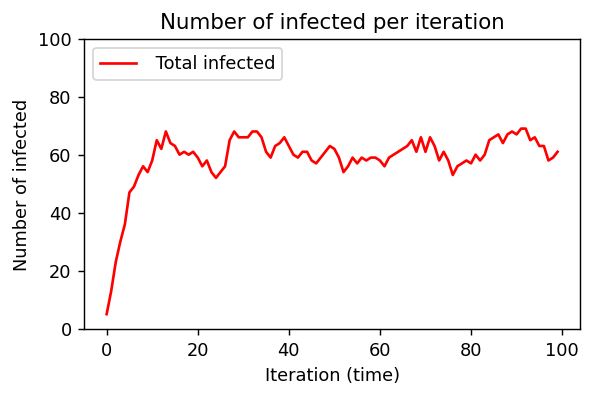

In [248]:
model = Model(num_of_agents=100, num_iterations=100, mode = 'homogeneous')
model.run()
model.graph_num_infected()
model.num_infected_per_iteration

In [183]:
# model = Model(num_of_agents=100, num_iterations=10)
# model.run()
# model.graph_num_infected()

In [6]:
# get_total = []
# #This runs the model 100 times, each model executing 10 steps.
# for j in range(100):
#     # Run the model
#     Model(num_of_agents=100, num_iterations=100)
#     for i in range(10):
#         model.run()

#     # Store the results
#     for agent in model.agents:
#         get_total.append(model.get_num_infected())

In [7]:
# plt.rcParams["figure.figsize"] = (20,10)
# plt.rcParams.update({'font.size': 22})

# plt.hist(get_total, color='#0504aa', alpha=0.7, rwidth=0.85)

# plt.grid(axis='y', alpha=0.6)
# plt.xlabel('No. Infected')
# plt.ylabel('Frequency')
# plt.title('Distribution of Number of Infected over Time')

## Creating Datasets for Calibration

In [8]:
get_total = []
#This runs the model 100 times
for j in range(1):
    # Run the model, each model is run 10 times
    base_model = Model(num_of_agents=10, num_iterations=10)
    for k in range(1):
        model = deepcopy(base_model)
        model.run()
        #t is number of interations, 
        #num_infected is the number of infected per iteration
        #copy_number is the number of times a single model is ran
        #model_number is model number
        for t, i in enumerate(model.num_infected_per_iteration):
            d = {'t': t,
                 'num_infected': i,
                 'copy_number': k,
                 'model_number': j}
            get_total.append(d)

In [9]:
df = pd.DataFrame(get_total)
# df.head()

In [10]:
df['copy_number'].unique()

array([0])

In [11]:
num_panicked = df['num_infected']

In [12]:
mean = statistics.mean(num_panicked)
sd = statistics.stdev(num_panicked)
print(mean)
print(sd)

7.4
3.3730961708462712


## ABC

### Creating Functions

In [424]:
def my_model(input_params_dict):
    """
    Creating the model function that feeds the ABC package my ABM.
    This function includes the creation of a dictionary, 
    which contains the parameter of interest: 'number of panicked' agents
    """
    beta = input_params_dict["param_b"]
    
    model = Model(num_of_agents=100, num_iterations=100, mode = 'homogeneous')
    model.beta = beta
    model.run()

    result = model.num_infected_per_iteration
    return {"model_result": result}

In [425]:
def distance(model_result_dict, observations_dict):
    """
    The function that calculates the absolute difference
    between my ABM results and the ABC observations.
    """
    model_result = model_result_dict['model_result']
    model_result = np.array(model_result)
    observation = observations_dict['observation'] 
    observation = np.array(observation)
    
    print(model_result)
    print(observation)
    print()
    return abs (model_result - observation).any()

In [426]:
PARAM_B = 0.1

In [427]:
truth_model = my_model({ "param_b": PARAM_B})
obs = truth_model['model_result']

### Defining Priors

In [428]:
"""
Here, I'm assuming that the 'Number of panicked' parameter is normally distributed
"""
param_b_rv = pyabc.RV("uniform", 0, 1)

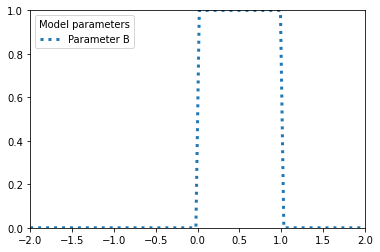

In [429]:
"""
Visualising this to see if plots are okay. 
"""
x = np.linspace(-2 ,2, 100)
lines = plt.plot(x, pyabc.Distribution(param=param_b_rv).pdf({"param": x}), ':',
                 label = "Parameter B", lw = 3)
plt.autoscale(tight=True)
plt.legend(title=r"Model parameters");
plt.show()

In [430]:
"""
Lower bound is 0, for the returned value
"""
priors = pyabc.Distribution(
    param_b=pyabc.LowerBoundDecorator(param_b_rv, 0.0))

### Running ABC and Visualisations

In [431]:
"""
Running the package
"""
abc = pyabc.ABCSMC(
    models=my_model,  
    parameter_priors=priors, 
    distance_function=distance,
    sampler=pyabc.sampler.SingleCoreSampler()
    #sampler=pyabc.sampler.MulticoreEvalParallelSampler()
    )

In [432]:
db_path = ("sqlite:///" + "abc_database.db")

In [433]:
run_id = abc.new(db_path, {'observation': obs})
print(f"Running new ABC with id {run_id}.... ", flush=True)

INFO:History:Start <ABCSMC id=92, start_time=2021-06-15 16:43:07.441022>


Running new ABC with id <pyabc.storage.history.History object at 0x7fcdbebc9690>.... 


In [434]:
abc_history = abc.run(max_nr_populations=10, minimum_epsilon=0.9)

INFO:ABC:Calibration sample t=-1.
INFO:Epsilon:initial epsilon is 1.0
INFO:ABC:t: 0, eps: 1.0.


[18 31 38 47 53 57 56 53 53 55 56 63 62 61 57 58 55 59 64 67 65 66 69 64
 65 57 59 60 64 60 66 68 62 63 64 62 58 53 58 60 59 56 56 62 67 66 66 67
 59 62 64 65 63 61 64 58 64 60 58 51 54 52 59 60 66 62 67 67 66 59 62 64
 65 65 67 66 66 70 67 70 71 70 68 61 57 65 62 56 57 60 65 63 68 71 70 66
 66 64 60 59]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 59 52 53 54 51 52 47 51 56 65 62 68 63 61 61 63 61 56 62 67 69 70
 65 68 66 64 69 65 61 62 62 55 57 61 62 65 66 63 65 61 64 61 63 65 57 64
 69 68 65 66 59 57 61 60 61 66 65 66 67 71 66 64 63 63 56 55 59 64 63 59
 55 59 61 65]

[21 33 42 50 58 53 59 58 60 65 65 68 68 63 59 60 61 62 66 67 64 58 57 62
 60 59 57 60 60 57 57 56 54 54 56 54 51 54 55 54 48 50 55 49 53 51 51 62
 63 65 66 67 66 65 62 60 59 56 58 62 66 61 60 62 54 54 59 64 63 64 63 59
 65 68 68 72 74 72 67 65 68 69 70 65 66 60 56 60 65 69 63 63 58 59 57 62
 60 57 60 61]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 5

INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 1.0.


[13 24 34 45 50 56 56 54 58 58 52 55 60 54 56 61 57 56 57 55 62 57 58 58
 55 55 53 56 52 51 58 54 55 63 61 63 64 62 63 63 66 64 59 60 62 60 60 61
 60 60 67 74 68 65 60 53 56 57 59 59 53 57 62 66 61 61 63 64 65 68 65 66
 69 70 71 72 69 68 66 65 61 63 66 60 55 61 63 63 64 60 64 67 60 62 62 57
 58 63 60 61]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 59 52 53 54 51 52 47 51 56 65 62 68 63 61 61 63 61 56 62 67 69 70
 65 68 66 64 69 65 61 62 62 55 57 61 62 65 66 63 65 61 64 61 63 65 57 64
 69 68 65 66 59 57 61 60 61 66 65 66 67 71 66 64 63 63 56 55 59 64 63 59
 55 59 61 65]

[12 20 30 44 48 53 57 59 58 62 59 60 65 60 60 59 65 63 63 66 61 66 68 65
 66 64 60 53 54 61 59 57 60 59 60 55 56 62 63 62 58 58 57 63 59 60 57 51
 52 57 64 67 64 65 67 68 62 68 66 68 60 61 62 58 61 64 57 57 56 55 49 57
 62 62 68 61 56 58 59 63 63 60 64 64 66 62 56 58 59 59 56 55 55 55 56 57
 60 58 60 65]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 5

INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.6104e+01.
INFO:ABC:t: 2, eps: 1.0.


[15 27 36 43 49 49 51 60 60 62 63 66 61 59 66 67 64 67 71 65 65 68 68 65
 66 66 71 65 62 63 67 65 66 64 68 69 70 65 68 67 63 61 59 63 65 70 61 59
 61 60 60 67 61 61 66 59 59 55 59 61 59 61 63 63 62 61 67 63 58 65 65 65
 66 65 65 63 60 58 60 62 55 53 53 59 55 58 58 58 62 60 57 59 62 61 60 64
 63 70 72 63]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 59 52 53 54 51 52 47 51 56 65 62 68 63 61 61 63 61 56 62 67 69 70
 65 68 66 64 69 65 61 62 62 55 57 61 62 65 66 63 65 61 64 61 63 65 57 64
 69 68 65 66 59 57 61 60 61 66 65 66 67 71 66 64 63 63 56 55 59 64 63 59
 55 59 61 65]

[15 28 36 42 50 51 54 52 49 57 59 60 64 61 57 63 63 58 59 63 66 67 66 63
 62 60 63 67 69 71 69 70 67 60 61 60 66 67 72 74 71 66 66 67 62 64 62 60
 63 68 64 58 58 57 56 54 56 55 56 58 60 56 60 62 63 59 56 57 58 61 54 56
 60 58 57 55 60 62 65 61 60 58 59 58 61 59 59 58 54 60 62 61 60 62 67 67
 69 70 69 67]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 5

INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.7169e+01.
INFO:ABC:t: 3, eps: 1.0.


[18 30 41 44 49 51 58 58 65 62 66 61 61 60 61 65 55 56 66 65 60 59 55 57
 58 62 59 56 64 66 61 64 63 68 71 67 65 62 61 54 57 61 58 53 51 57 60 62
 63 61 58 60 64 64 62 59 58 57 60 59 61 62 67 61 66 68 66 65 62 58 56 59
 59 61 62 62 57 62 61 55 49 48 49 49 56 60 62 63 58 58 60 63 63 69 72 62
 60 55 59 64]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 59 52 53 54 51 52 47 51 56 65 62 68 63 61 61 63 61 56 62 67 69 70
 65 68 66 64 69 65 61 62 62 55 57 61 62 65 66 63 65 61 64 61 63 65 57 64
 69 68 65 66 59 57 61 60 61 66 65 66 67 71 66 64 63 63 56 55 59 64 63 59
 55 59 61 65]

[11 24 35 42 41 52 56 65 64 64 66 57 58 57 54 55 54 56 60 59 58 54 59 60
 60 55 58 58 54 59 58 61 62 63 60 59 60 57 60 63 55 58 58 53 57 61 58 62
 53 55 58 58 53 52 46 52 57 65 67 65 57 52 61 60 59 61 61 64 59 60 56 55
 59 54 53 58 60 66 58 58 60 63 60 58 61 60 67 66 57 53 58 61 62 60 58 59
 63 57 58 58]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 5

INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=8.9646e+01.
INFO:ABC:t: 4, eps: 1.0.


[12 23 35 41 51 50 47 48 51 54 61 60 61 60 70 74 68 69 64 63 56 49 54 63
 65 67 66 70 67 62 59 57 55 57 57 55 59 57 56 57 55 51 54 59 52 55 55 60
 64 64 66 64 64 64 64 62 60 64 65 65 64 68 70 64 64 60 63 62 59 56 60 57
 57 57 51 57 53 58 62 62 58 57 61 64 65 66 65 59 58 59 62 66 64 67 70 65
 68 64 62 65]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 59 52 53 54 51 52 47 51 56 65 62 68 63 61 61 63 61 56 62 67 69 70
 65 68 66 64 69 65 61 62 62 55 57 61 62 65 66 63 65 61 64 61 63 65 57 64
 69 68 65 66 59 57 61 60 61 66 65 66 67 71 66 64 63 63 56 55 59 64 63 59
 55 59 61 65]

[18 27 39 42 46 51 59 58 53 53 53 57 56 60 60 63 60 62 61 62 62 59 60 58
 62 66 61 61 57 59 61 63 58 59 59 63 63 54 59 58 58 61 60 62 63 60 64 62
 66 65 67 63 62 61 56 61 58 56 58 56 58 58 62 64 58 57 61 60 55 59 54 55
 52 57 57 62 58 62 64 68 67 65 63 62 65 66 62 58 61 58 59 60 61 57 61 64
 64 64 62 59]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 5

INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.7000e+01.
INFO:ABC:t: 5, eps: 1.0.


[16 25 38 43 50 55 57 62 66 68 68 61 59 59 55 57 57 57 54 59 65 62 58 64
 58 60 65 59 56 57 58 58 57 65 61 56 58 66 64 62 70 62 63 68 66 67 66 63
 63 66 68 64 67 65 61 55 58 59 63 63 63 65 67 56 61 53 56 58 57 62 61 62
 66 69 71 74 73 76 73 68 70 69 68 61 67 72 70 67 68 59 61 68 60 60 66 66
 66 61 63 57]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 59 52 53 54 51 52 47 51 56 65 62 68 63 61 61 63 61 56 62 67 69 70
 65 68 66 64 69 65 61 62 62 55 57 61 62 65 66 63 65 61 64 61 63 65 57 64
 69 68 65 66 59 57 61 60 61 66 65 66 67 71 66 64 63 63 56 55 59 64 63 59
 55 59 61 65]

[19 33 39 44 47 52 55 57 54 53 57 59 60 56 60 63 65 62 63 62 57 59 58 59
 60 62 54 55 53 60 61 61 68 64 65 66 60 54 60 59 63 68 62 63 63 58 59 61
 59 66 65 64 58 57 61 65 68 63 63 59 63 64 64 63 68 64 62 63 63 63 65 58
 62 67 61 55 55 52 55 62 61 67 70 71 72 71 66 68 63 61 63 60 59 64 61 63
 61 58 64 58]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 5

INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.8482e+01.
INFO:ABC:t: 6, eps: 1.0.


[14 31 37 37 42 48 54 57 51 50 50 56 56 61 60 57 60 62 65 64 67 68 68 65
 69 65 63 62 61 62 69 63 63 66 61 63 54 52 56 61 61 56 61 66 65 69 66 64
 66 65 58 62 67 61 60 57 57 61 58 56 61 61 66 69 66 65 61 66 63 62 64 60
 61 66 72 69 65 55 55 54 57 53 57 60 64 66 62 62 61 64 64 65 58 57 65 67
 67 66 66 62]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 59 52 53 54 51 52 47 51 56 65 62 68 63 61 61 63 61 56 62 67 69 70
 65 68 66 64 69 65 61 62 62 55 57 61 62 65 66 63 65 61 64 61 63 65 57 64
 69 68 65 66 59 57 61 60 61 66 65 66 67 71 66 64 63 63 56 55 59 64 63 59
 55 59 61 65]

[21 23 32 39 48 52 55 57 60 63 63 66 70 64 63 64 61 59 61 60 62 57 46 46
 56 57 57 56 56 60 65 65 65 62 58 58 57 61 63 65 64 65 62 60 56 67 66 67
 66 67 62 60 61 58 60 58 60 65 60 53 51 58 54 49 50 55 58 55 61 65 54 62
 64 63 61 63 61 61 59 63 64 66 74 66 62 63 62 61 64 68 65 68 66 66 65 66
 64 66 64 63]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 5

INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.5573e+01.
INFO:ABC:t: 7, eps: 1.0.


[17 32 34 45 53 53 52 56 60 62 67 66 61 58 56 59 58 58 53 55 53 54 52 54
 55 61 59 56 61 60 58 60 63 67 68 71 71 70 65 61 62 62 62 57 57 56 62 68
 60 60 66 67 66 68 63 65 63 61 64 60 60 63 56 55 54 52 54 54 57 58 62 61
 63 52 53 56 59 64 62 58 61 59 61 60 63 63 58 56 55 59 57 59 61 66 68 68
 64 60 61 66]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 59 52 53 54 51 52 47 51 56 65 62 68 63 61 61 63 61 56 62 67 69 70
 65 68 66 64 69 65 61 62 62 55 57 61 62 65 66 63 65 61 64 61 63 65 57 64
 69 68 65 66 59 57 61 60 61 66 65 66 67 71 66 64 63 63 56 55 59 64 63 59
 55 59 61 65]

[16 28 40 44 54 54 51 54 59 64 64 71 70 68 65 59 64 66 68 64 68 70 64 63
 58 56 48 57 57 62 60 60 56 55 60 56 55 63 61 64 63 61 65 64 60 64 67 66
 64 60 63 68 66 68 61 59 63 64 63 67 62 61 60 58 59 59 64 57 53 55 63 63
 62 60 62 65 66 62 59 70 68 66 63 65 64 62 58 60 64 59 54 58 57 63 65 69
 66 65 65 64]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 5

INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.5151e+01.
INFO:ABC:t: 8, eps: 1.0.


[10 20 30 35 38 42 48 53 54 52 52 52 55 57 60 60 65 71 67 64 62 62 66 64
 68 63 60 60 61 55 57 54 55 55 51 55 57 56 62 58 57 58 62 62 61 61 61 67
 65 64 66 66 61 66 68 71 68 64 63 64 61 62 60 56 53 62 61 61 66 64 64 60
 56 58 63 62 60 66 67 64 64 59 59 54 54 51 50 48 53 61 63 63 68 73 70 74
 74 72 72 68]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 59 52 53 54 51 52 47 51 56 65 62 68 63 61 61 63 61 56 62 67 69 70
 65 68 66 64 69 65 61 62 62 55 57 61 62 65 66 63 65 61 64 61 63 65 57 64
 69 68 65 66 59 57 61 60 61 66 65 66 67 71 66 64 63 63 56 55 59 64 63 59
 55 59 61 65]

[15 26 33 36 41 46 52 56 58 60 63 60 63 62 62 64 62 62 65 64 63 64 67 61
 67 65 60 55 55 53 53 62 64 64 62 62 60 62 66 67 64 63 66 63 60 62 63 65
 73 73 69 69 60 61 56 62 61 64 62 60 63 64 62 64 68 59 66 67 60 57 57 60
 62 56 61 57 57 60 59 68 66 67 68 66 63 65 60 54 56 61 60 65 62 58 64 65
 65 63 66 67]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 5

INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.1232e+01.
INFO:ABC:t: 9, eps: 1.0.


[17 35 41 48 59 62 62 55 56 51 50 55 52 52 57 56 60 58 58 58 59 60 58 58
 57 59 63 59 60 65 63 66 60 58 61 57 53 61 65 63 66 61 60 58 60 65 63 62
 61 62 60 64 60 63 65 64 62 58 56 56 51 56 58 54 58 62 63 63 60 63 63 68
 65 60 63 61 58 63 59 68 67 66 69 65 65 62 57 59 58 58 55 53 57 56 53 54
 52 51 52 49]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 59 52 53 54 51 52 47 51 56 65 62 68 63 61 61 63 61 56 62 67 69 70
 65 68 66 64 69 65 61 62 62 55 57 61 62 65 66 63 65 61 64 61 63 65 57 64
 69 68 65 66 59 57 61 60 61 66 65 66 67 71 66 64 63 63 56 55 59 64 63 59
 55 59 61 65]

[13 28 36 40 47 54 57 58 59 58 58 58 61 65 65 66 68 67 66 64 61 62 64 65
 68 66 66 64 65 64 65 67 62 54 56 54 52 49 48 55 53 54 52 60 61 60 63 66
 58 57 61 58 64 63 68 67 62 62 66 70 69 67 65 63 58 63 62 66 65 58 60 55
 56 57 54 54 56 58 63 62 65 65 66 62 65 64 59 60 61 54 54 46 51 55 53 59
 58 58 60 59]
[14 26 36 39 45 48 46 51 54 54 55 58 62 62 65 60 61 63 67 65 65 67 68 67
 60 59 5

INFO:ABC:Acceptance rate: 100 / 100 = 1.0000e+00, ESS=9.8230e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC id=92, duration=0:01:59.242202, end_time=2021-06-15 16:45:06.683224>


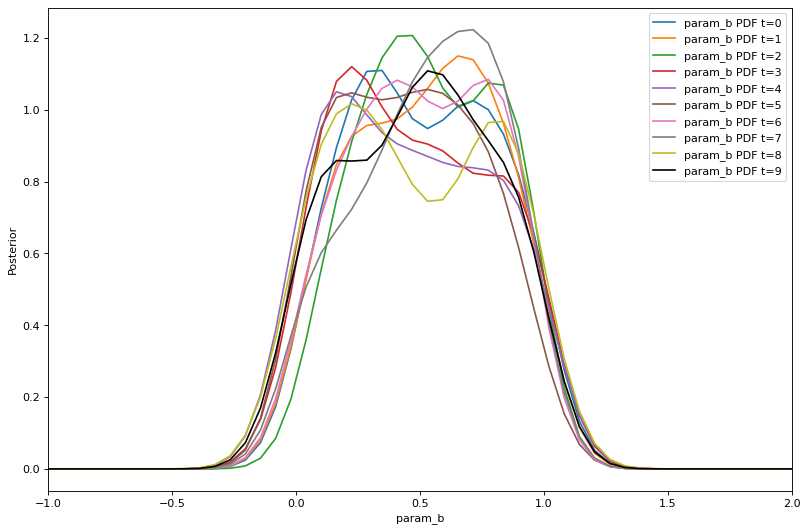

In [435]:
fig, ax = plt.subplots(figsize=(12,8), dpi=80)
for i, param in enumerate(priors.keys()):
    for t in range(abc_history.max_t+1):
        df, w = abc_history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, xmin = -1, xmax= 2,
                                        label=f"{param} PDF t={t}",
                                        # Make earlier populations transparent
                                        color="black" if t == abc_history.max_t else None  # Make the last one black
                                        )
ax.legend()
fig.savefig('posterior.png')

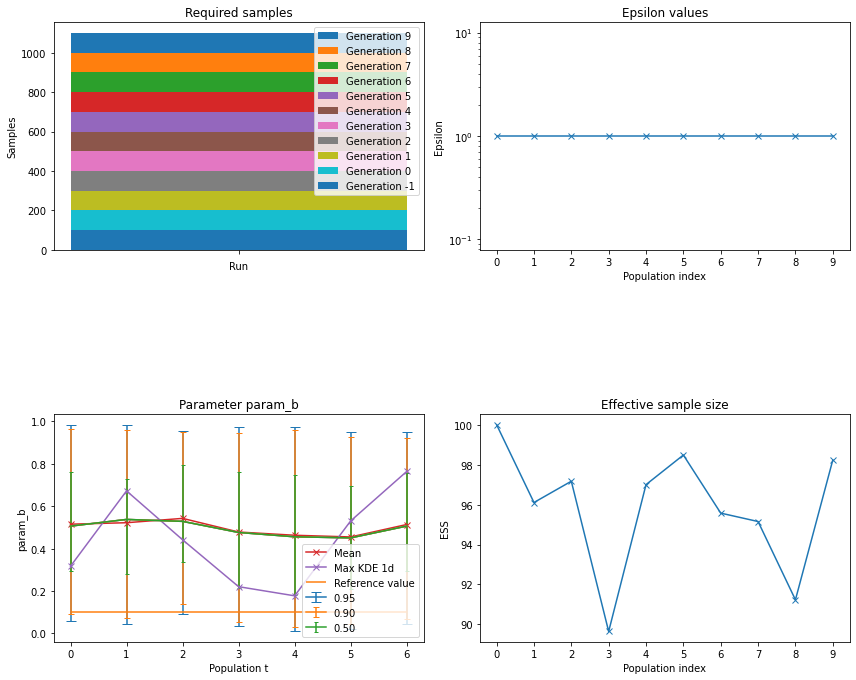

In [436]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(abc_history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(abc_history, ax=arr_ax[0][1])
pyabc.visualization.plot_effective_sample_sizes(abc_history, ax=arr_ax[1][1])
pyabc.visualization.plot_credible_intervals(
    abc_history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4, 5, 6],
    show_mean=True, show_kde_max_1d=True,
    refval={'param_b': 0.1}, arr_ax=arr_ax[1][0])

plt.gcf().set_size_inches((12, 10))
plt.gcf().tight_layout()
plt.savefig('posterior_output.png')

In [437]:
for i, param in enumerate(priors.keys()):
    for t in range(abc_history.max_t+1):
        df, w = abc_history.get_distribution(m=0, t=t)
        X, Y = pyabc.visualization.kde.kde_1d(df, w, x = param)
        mode = X[np.where(Y == max(Y))]
        print('t:%d, mode:%f' % (t, mode))

t:0, mode:0.326663
t:1, mode:0.672500
t:2, mode:0.445076
t:3, mode:0.219392
t:4, mode:0.185346
t:5, mode:0.538849
t:6, mode:0.764735
t:7, mode:0.694981
t:8, mode:0.226238
t:9, mode:0.549521


## Infected plotting example

In [25]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams.update({'font.size': 14})

In [ ]:
# small_data = df.loc[df['model_number']==0, :]
# small_data.shape

In [ ]:
# copy_numbers = small_data['copy_number'].unique()

# plt.figure()
# #tdf temporary dataframe to keep info within
# for copy_number in copy_numbers:
#     tdf = small_data.loc[small_data['copy_number']==copy_number, :]
#     plt.plot(tdf['t'], tdf['num_infected'], label=copy_number)
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Number of infected')
# plt.show()

In [ ]:
# import seaborn as sns
# plt.figure()
# sns.lineplot(data=small_data, x='t', y='num_infected', hue='copy_number')
# plt.show()